In [1]:
import os
import pandas as pd
import seaborn as sns
from sklearn.dummy import DummyClassifier
from sklearn.metrics import f1_score
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
import dvc.api
import numpy as np
from sklearn.decomposition import PCA
from sklearn.impute import KNNImputer
params = dvc.api.params_show()

start_file = params['processing']['target_file']


df_all = pd.read_json(start_file, lines=True)
df_all['reviewTextLength'] = df_all['reviewText'].astype(str).apply(len)
df_all['numbers_amount'] = df_all['reviewText'].str.count(r'\d+')

In [2]:
print('Liczba klas:', df_all['overall'].nunique())
class_counts = df_all['overall'].value_counts()
print(class_counts)

Liczba klas:

5

5    14391
4     4041
3     2465
1     1741
2      889
Name: overall, dtype: int64

In [3]:
max_value = df_all['overall'].max()
min_value = df_all['overall'].min()
print('Skala Overall od', min_value,'do', max_value)

Skala Overall od

1

do

5

In [4]:
df_all.dtypes

overall               int64
verified               bool
reviewTime           object
reviewerID           object
asin                 object
style                object
reviewerName         object
reviewText           object
summary              object
unixReviewTime        int64
vote                 object
image                object
data_origin          object
reviewTextLength      int64
numbers_amount      float64
dtype: object

In [5]:
df_all.head()

,overall,verified,reviewTime,reviewerID,asin,style,reviewerName,reviewText,summary,unixReviewTime,vote,image,data_origin,reviewTextLength,numbers_amount
0,5,True,"09 1, 2016",A3CIUOJXQ5VDQ2,B0000530HU,"{'Size:': ' 7.0 oz', 'Flavor:': ' Classic Ice ...",Shelly F,As advertised. Reasonably priced,Five Stars,1472688000,None,None,All_Beauty_5.json,32,0.0
1,5,True,"11 14, 2013",A3H7T87S984REU,B0000530HU,"{'Size:': ' 7.0 oz', 'Flavor:': ' Classic Ice ...",houserules18,Like the oder and the feel when I put it on my...,Good for the face,1384387200,None,None,All_Beauty_5.json,207,0.0
2,1,True,"08 18, 2013",A3J034YH7UG4KT,B0000530HU,"{'Size:': ' 7.0 oz', 'Flavor:': ' Classic Ice ...",Adam,I bought this to smell nice after I shave. Wh...,Smells awful,1376784000,None,None,All_Beauty_5.json,142,1.0
3,5,False,"05 3, 2011",A2UEO5XR3598GI,B0000530HU,"{'Size:': ' 7.0 oz', 'Flavor:': ' Classic Ice ...",Rich K,HEY!! I am an Aqua Velva Man and absolutely lo...,Truth is There IS Nothing Like an AQUA VELVA MAN.,1304380800,25,None,All_Beauty_5.json,1417,4.0
4,5,True,"05 6, 2011",A3SFRT223XXWF7,B00006L9LC,{'Size:': ' 200ml/6.7oz'},C. C. Christian,If you ever want to feel pampered by a shampoo...,Bvlgari Shampoo,1304640000,3,None,All_Beauty_5.json,237,0.0


Atrybuty verified , reviewerId, asin, reviewerName, data_origin (łącznie 5) są to zmienna kategoryczna

Atrybuty reviewTime, unixReviewTime, vote, reviewTextLength, numbers_amount (łacznie 5) są to zmienna numeryczne

Oprócz tego mamy adres URL (image), z którego może zostać pobrany obraz o różnym rozmiarze. Zdjęcia zawierają zdjęcia produktu od recenzującego.

Dodatokw atrybut style przechowuje słownik mogący rozbudować atrybuty jednak wynikałoby z tego pojawienie się wielu NaN, oraz trudno porównać rozmiar szamponu i ubrania


Zmienna wyjściowa można interpretować jako zmienną numeryczną co może pomóc w szukaniu korelacji jednak nie jest to preferowane. Jest to zmienna dyskretna, która może przyjąć jedną z kilku wartości/ kategori. Ludzie nie myślą o produkcie 2/5 jako o dwa razy gorszym od 4/5. Ludzie mają wyuczone pewne interpretacje ocen w typowych skaklach oceniania (1-5, 1-10), które interpretują raczej w sposób opisowy. W jakijś książce czytałem, że przeskalowanie takich skal na dziwne skale np. od 47-73 całkowicie zaburzało postrzeganie oceny. Zaczęto otrzymywać odmienne rozkłady etc.

In [6]:
percent_na_counts = df_all.isna().sum() / len(df_all) * 100

percent_na_counts = percent_na_counts.sort_values(ascending=False)
print("procent brakujących wartośći")
print(percent_na_counts)

procent brakujących wartośći

image               95.311769
vote                70.990777
style               36.540995
reviewText           0.093510
numbers_amount       0.093510
summary              0.046755
reviewerName         0.038254
overall              0.000000
verified             0.000000
reviewTime           0.000000
reviewerID           0.000000
asin                 0.000000
unixReviewTime       0.000000
data_origin          0.000000
reviewTextLength     0.000000
dtype: float64

In [7]:
df_all.loc[df_all['vote'] == '0'].head(1)

,overall,verified,reviewTime,reviewerID,asin,style,reviewerName,reviewText,summary,unixReviewTime,vote,image,data_origin,reviewTextLength,numbers_amount


In [8]:
df_all.loc[df_all['vote'] == '1'].head(1)

,overall,verified,reviewTime,reviewerID,asin,style,reviewerName,reviewText,summary,unixReviewTime,vote,image,data_origin,reviewTextLength,numbers_amount


In [9]:
(pd.to_numeric(df_all['vote'], errors='coerce') < 0).any()

False

In [10]:
#dopiero teraz isteniją rekordy z vote
df_all.loc[df_all['vote'] == '2'].head(1)

,overall,verified,reviewTime,reviewerID,asin,style,reviewerName,reviewText,summary,unixReviewTime,vote,image,data_origin,reviewTextLength,numbers_amount
26,1,True,"04 13, 2018",A2M1OW141Y5WSN,B00006L9LC,{'Size:': ' Small'},Vinny,Selenium appeared in my search results when I ...,I was super excited to see the 5 star review,1523577600,2,None,All_Beauty_5.json,438,3.0


Obrazki są dołączone tylko do 5% rekordów. Dodatkowym pytaniem jest ile z tych linków jest działających <br>
Tylko 30% rekordów posiada "vote" możliwe, że, gdy vote = 0 było jednoznaczne z wpisaniem NaN, ponieważ brakuje wartośći 0. Brakuje jednak także wartośći 1, które zapewne też byłby liczne co utrudnia potwierdzenie tej hipotezy <br> Wydaje się niemożliwym uzupełnienie braków reviewText. Na szczęśnie jest ich niewiele. Można byłoby skupić się na badaniu summary, ponieważ jest ich więcej nie zawierają jednak tyle potencjalnych informacji. <br>
Braki w numbers_amount wynikają z braków w reviewText <br>
Isteniją braki w reviewerName jednka teoretycznie powinna być funkcja 1-1, która zastąpiłaby je reviewerID

In [11]:
df_all_tmp = df_all.drop('style', axis=1)
df_all_tmp = df_all_tmp.drop('image', axis=1)
print("Ogólnie jest duplikatów:", round((len(df_all_tmp) - len(df_all_tmp.drop_duplicates()))/len(df_all_tmp), 1), '%')

Ogólnie jest duplikatów:

0.2

%

Możliwe, że pojawiają się obrazki jednym z dwóch duplikatów, albo dodatkowe informacje w style. Wymagalo dalszego zbadania

<Axes: >

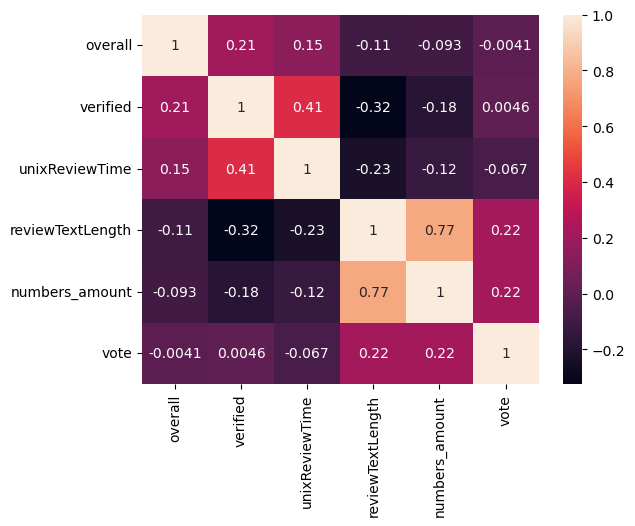

In [12]:
selected_columns = ['overall', 'verified', 'unixReviewTime', 'reviewTextLength', 'numbers_amount', 'vote']
df_all_tmp['vote'] = df_all_tmp['vote'].str.replace(',', '.').astype(float)
df_all_numeric = df_all_tmp[selected_columns]
df_all_numeric = df_all_numeric.drop_duplicates()
corr = df_all_numeric.corr(numeric_only=False)

sns.heatmap(corr, label=True, annot=True)

Wydaj 3 największe korelacje: <br>
numbers_amount:reviewTextLenght - wydaje się logicznym, że tym dłuższy tekst tym więcej liczb tam będzie <br>
verified:unixReviewTime -  wydaje się logicznym, że tym starsza ocena tym większa szansa na weryfikację. Tutaj jednka ty więszky timeStamp tym większa szansa na weryfikacje co może świadczyć, że dopiero od niedawna zaczęto weryfikować i stare oceny nie są weryfikowane już <br>
verified:reviewTextLength - chętniej są weryfikowane krótkie teksty

Overall nie ma wysokiej korelacji z jakąkolwiek zmienną. Największa korelacja overall:verified może świadczyć, że częściej weryfikowane są wyższe oceny

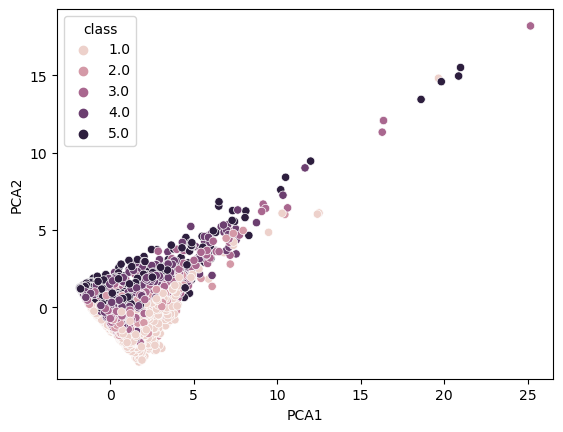

In [13]:
def standarize(df):
    return StandardScaler().fit_transform(df.iloc[:,0:-1].values), df['overall'].values, df.columns

df_all_numeric = df_all_numeric.drop_duplicates()
imputer = KNNImputer(n_neighbors=5)
df_all_numeric = pd.DataFrame(imputer.fit_transform(df_all_numeric),columns = df_all_numeric.columns)
data_all_numeric_std = standarize(df_all_numeric)
model = PCA(n_components=2)
df_all_numeric_std = data_all_numeric_std[0]
Y_pca = model.fit_transform(df_all_numeric_std)
df_pca = pd.DataFrame(Y_pca, columns=('PCA1', "PCA2"))
df_pca['class'] = data_all_numeric_std[1]
sns.scatterplot(x=df_pca['PCA1'], y=df_pca['PCA2'], hue=df_pca['class'])
plt.show()

Same zmienne numeryczne, posiadają  pewien potencjał widać wyraźnie, że dla dwóch komponentów PCA można już rozróźniać dobre i złe oceny

<Axes: >

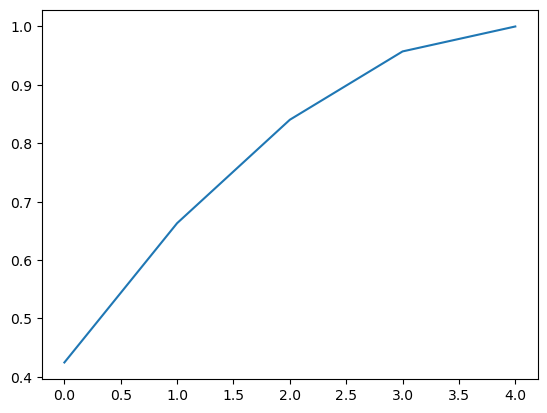

In [14]:
model_2 = PCA().fit(df_all_numeric_std)
sns.lineplot(data=np.cumsum(model_2.explained_variance_ratio_))

In [15]:
import string
import nltk
from collections import Counter
nltk.download('stopwords')
text_column = df_all['reviewText']

stop_words = nltk.corpus.stopwords.words('english')
text_column = text_column.str.lower().str.replace('[{}]'.format(string.punctuation), '')
text_column = text_column.apply(lambda x: ' '.join([word for word in str(x).split() if word not in stop_words]))

words = ' '.join(text_column).split()
word_freq = Counter(words)
sorted_words = sorted(word_freq.items(), key=lambda x: x[1], reverse=True)
top_words = sorted_words[:20]
print(top_words)


[nltk_data] Downloading package stopwords to /home/kaka/nltk_data...

[nltk_data]   Package stopwords is already up-to-date!

/tmp/ipykernel_53202/2734960095.py:8: FutureWarning: The default value of regex will change from True to False in a future version.
  text_column = text_column.str.lower().str.replace('[{}]'.format(string.punctuation), '')


[('use', 12475), ('software', 11347), ('one', 10889), ('like', 9573), ('product', 9017), ('time', 8797), ('get', 8460), ('windows', 7960), ('vent', 7832), ('program', 7566), ('would', 6835), ('great', 6821), ('version', 6746), ('good', 6577), ('dryer', 6410), ('used', 6350), ('using', 6243), ('well', 6172), ('really', 5848), ('dont', 5466)]

Łatwo rozpoznać słowa mogące świadczyć o sentymencie "great", 'well", "good" możliwe, żę "like"

In [16]:
df1 = df_all[df_all['overall'] == 1]
df2 = df_all[df_all['overall'] == 2]
df3 = df_all[df_all['overall'] == 3]
df4 = df_all[df_all['overall'] == 4]
df5 = df_all[df_all['overall'] == 5]

def word_frequency(df):
    text_column = df['reviewText']
    text_column = text_column.str.lower().str.replace('[{}]'.format(string.punctuation), '')
    text_column = text_column.apply(lambda x: ' '.join([word for word in str(x).split() if word not in stop_words]))
    words = ' '.join(text_column).split()
    word_freq = Counter(words)
    return word_freq

wf1 = word_frequency(df1)
wf2 = word_frequency(df2)
wf3 = word_frequency(df3)
wf4 = word_frequency(df4)
wf5 = word_frequency(df5)

/tmp/ipykernel_53202/1968566922.py:9: FutureWarning: The default value of regex will change from True to False in a future version.
  text_column = text_column.str.lower().str.replace('[{}]'.format(string.punctuation), '')


In [17]:
def top_words(word_freq, n):
    sorted_words = sorted(word_freq.items(), key=lambda x: x[1], reverse=True)
    top_words = [w[0] for w in sorted_words[:n]]
    return set(top_words)

top_n = 30
overall_words = {}
overall_words[1] = top_words(wf1, top_n)
overall_words[2] = top_words(wf2, top_n)
overall_words[3] = top_words(wf3, top_n)
overall_words[4] = top_words(wf4, top_n)
overall_words[5] = top_words(wf5, top_n)

print("Specyficzne słowa z top 30 najczęstszych dla najgorszch ocen")
print(overall_words[1] - overall_words[3] - overall_words[4] - overall_words[5])
print("Specyficzne słowa z top 30 najczęstszych dla najlpeszych ocen")
print(overall_words[5] - overall_words[3] - overall_words[2] - overall_words[1])

Specyficzne słowa z top 30 najczęstszych dla najgorszch ocen

{'quicken', 'back', 'support', 'microsoft', '7', 'norton', 'install', 'upgrade', 'problem', 'vista', 'system'}

Specyficzne słowa z top 30 najczęstszych dla najlpeszych ocen

{'drill', 'dryer', 'easy', 'didnt', 'great', 'lint', 'clean', 'love'}

Widać dużo jednoznacznie dobrych przymiotników przy ocenach = 5 <br>
Przy ocench = 1 widać, że istnieją problemy w systemem microsofut vista lub 7 i w zmianach oprogramowania.

In [18]:
text_length = df_all['reviewText'].astype(str).apply(len)
print("Całkowita długość tekstu: ", text_length.mean(), 'znaków')
print("Średnia długość tekstu: ", text_length.mean(), 'znaków')
print("Maksymalna długość tekstu: ", text_length.max(), 'znaków')
nltk.download('gutenberg')
nltk.download('punkt')

text = nltk.corpus.gutenberg.raw('melville-moby_dick.txt')
words = nltk.word_tokenize(text)
non_unique_words = len(words) - len(set(words))

print("Co stanowi ", round(text_length.max()/non_unique_words*100, 1), '% ksiązki "Moby Dick"')
print("Minimalna długość tekstu: ", text_length.min(), 'znaków')
# w sumie mogłęm wykorzystać kolumnę którą stworzyłem:p

Całkowita długość tekstu: 

746.7728142134569

znaków

Średnia długość tekstu: 

746.7728142134569

znaków

Maksymalna długość tekstu: 

31644

znaków

[nltk_data] Downloading package gutenberg to /home/kaka/nltk_data...

[nltk_data]   Package gutenberg is already up-to-date!

[nltk_data] Downloading package punkt to /home/kaka/nltk_data...

[nltk_data]   Package punkt is already up-to-date!

Co stanowi 

13.5

% ksiązki "Moby Dick"

Minimalna długość tekstu: 

1

znaków

In [19]:
import collections

words = text_column.str.cat(sep=' ').split()
word_freq = collections.Counter(words)

print("Liczba unikalnych słów: ", len(word_freq))
print("W Panu Tadeuszu jest 2x więcej unikalnych słów")

Liczba unikalnych słów: 

37315

W Panu Tadeuszu jest 2x więcej unikalnych słów

In [20]:
max_length_idx = df_all['reviewText'].str.len().idxmax()
max_length_row = df_all.loc[max_length_idx]

print("Wiersz z maksymalną długością tekstu: ")
print(max_length_row['reviewText'])

Wiersz z maksymalną długością tekstu: 

 Fuzzy Wuzzy's Summary:
 Highly recommended with warm fuzzies!

 Design & Features:  Excellent 5-fuzzies rating
 Ergonomics & Usability:  Average not-good not-bad 3-fuzzies rating
 Performance, Stability & Reliability:  Excellent 5-fuzzies rating
 Competitive Pricing & Value:  Excellent 5-fuzzies rating

 Positives:

 Many stability and performance issues from the previous X3 versions of both PaintShop Pro and VideoStudio Pro were resolved in this X4 version. It runs noticeably quicker, even on slower 5-year old laptops and small netbooks, with good stability.
 PaintShop Pro X4 offers a very wide range of tools for both photo editing and graphic design, ranging from serious photography-specific tools to fun graphics manipulation.
 PaintShop Pro X4 combines photo editing, photo retouching, painting, drawing, graphics design, and image management in a single package.
 PaintShop Pro X4 has a great selection of photo enhancement tools, both to fix common photography issues and also more es

Należy przeprowadzić dogłebną anlizę reviewText oraz summary, mogą zawierać wiele dodatkowych przydatnych inforamcji pomagających ustalić overall. Należałoby również spróbować zamieć datę na zmienną kategoryczną mówiącą np. o okresach w roku (przed Świętami, wakacje, początek roku szkolnego) może pomogłoby to znaleźć powiązania. Także samo sprawdzenie, czy obecność zdjęcia/ ich ilość jak wpływa na overall. Połączenie tego z danymi numerycznymi może pomóc stowrzyć model klasyfikiacji o wysokim stopniu accuracy